In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import tensorflow.keras as keras

In [7]:
data = pd.read_csv('./cleaned_gps/6/interpolated_6_final.csv')
screen_coords = pd.read_csv('./screenspace_coords/6_xy.csv', names = ['x','y'])

In [23]:
RH_Point = np.array([-117.2244901, 32.6990683])
CAM = np.array([-117.2344652, 32.7029769])
RHS = (RH_Point-CAM)/np.linalg.norm(RH_Point-CAM)

In [31]:
RHS_Ang = np.arctan2(RHS[1],RHS[0])

In [58]:
angles = np.arctan2(full_data_6.lat_lin.values,full_data_6.lon_lin.values)

In [63]:
full_data_6['angles'] = angles

In [98]:
full_data_6

,Frame No.,UTC Timestamp,estimated_time,boat_lat_rel,boat_lon_rel,time,lat_lin,lon_lin,x,y,R,angles
0,0,19:33:54,19:33:58.36,NaN,NaN,0.00,-0.000087,0.001176,907.5000,449.000,0.001179,-0.074127
1,1,19:33:54,19:33:58.4,NaN,NaN,0.04,-0.000087,0.001176,908.2945,448.933,0.001179,-0.074127
2,2,19:33:54,19:33:58.44,NaN,NaN,0.08,-0.000087,0.001176,909.0050,448.855,0.001179,-0.074127
3,3,19:33:54,19:33:58.48,NaN,NaN,0.12,-0.000087,0.001176,910.5300,448.852,0.001179,-0.074127
4,4,19:33:54,19:33:58.52,NaN,NaN,0.16,-0.000087,0.001176,911.3060,448.817,0.001179,-0.074127
...,...,...,...,...,...,...,...,...,...,...,...,...
3595,3595,19:36:24,19:36:27.16,NaN,NaN,143.80,0.000188,0.000955,587.1185,454.023,0.000973,0.194575
3596,3596,19:36:24,19:36:27.2,NaN,NaN,143.84,0.000188,0.000955,586.3945,453.972,0.000973,0.194575
3597,3597,19:36:24,19:36:27.24,NaN,NaN,143.88,0.000188,0.000955,585.7030,453.905,0.000973,0.194575
3598,3598,19:36:24,19:36:27.28,NaN,NaN,143.92,0.000188,0.000955,585.0565,453.930,0.000973,0.194575


In [230]:
a = (full_data_6.angles.values-RHS_Ang) / (np.sin((1280-full_data_6.x.values)/1280)*np.pi)

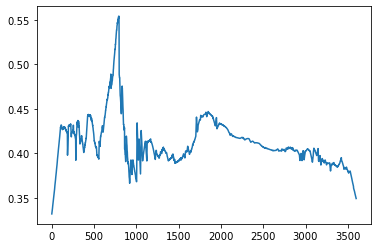

In [231]:
plt.plot(a)

In [236]:
rel_ang = full_data_6.angles.values-RHS_Ang

In [237]:
pred_ang = np.mean(a)*np.sin((1280-data.x.values)/1280*np.pi)

In [239]:
((rel_ang-pred_ang)**2).mean()

0.08149611326351744

In [96]:
np.mean(a)*180/np.pi

71.56739645393593

In [93]:
1.2*180/np.pi

68.75493541569878

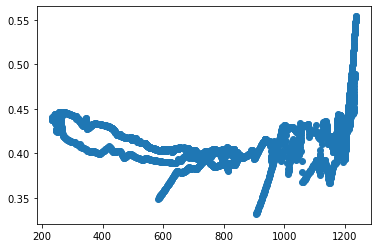

In [226]:
plt.scatter(full_data_6.x.values,a)

In [79]:
1280-643

637

In [87]:
1280/637

2.009419152276295

In [88]:
COV = np.array([-117.2192825,32.7060566])
np.arccos(np.dot(RH_Point-CAM,COV-CAM)/np.linalg.norm(COV-CAM)/np.linalg.norm(RH_Point-CAM))*180/np.pi*2.009419152276295

66.03649611554884

In [104]:
full_data_6[['x','y']]/np.array([1280,720])

,x,y
0,0.708984,0.623611
1,0.709605,0.623518
2,0.710160,0.623410
3,0.711352,0.623406
4,0.711958,0.623357
...,...,...
3595,0.458686,0.630588
3596,0.458121,0.630517
3597,0.457580,0.630424
3598,0.457075,0.630458


In [206]:
model = keras.models.Sequential([
    keras.layers.Dense(16, activation = 'linear'),
    keras.layers.Dense(16, activation = 'linear'),
    keras.layers.Dense(16, activation = 'linear'),
    keras.layers.Dense(16, activation = 'linear'),
    keras.layers.Dense(16, activation = 'linear'),
    keras.layers.Dense(16, activation = 'linear'),
    keras.layers.Dense(2, activation = 'linear')
])
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.MeanSquaredError(),
    metrics=[keras.metrics.MeanSquaredError()],
)


In [207]:
maxes = np.array([max(full_data_6.lon_lin),max(full_data_6.lat_lin)])

In [212]:
model.fit((full_data_6[['x','y']].values/np.array([1280,720]))[:3000],full_data_6[['R','angles']].values[:3000],#/maxes,
          validation_data =(full_data_6[['x','y']].values[3000:]/np.array([1280,720]),full_data_6[['R','angles']].values[3000:]),#/maxes), 
         batch_size = 8,
         epochs = 50,
         verbose = 1)

Epoch 1/50
375/375 [==============================] - 1s 2ms/step - loss: 0.0045 - mean_squared_error: 0.0045 - val_loss: 4.3255e-04 - val_mean_squared_error: 4.3255e-04
Epoch 2/50
375/375 [==============================] - 1s 2ms/step - loss: 1.2359e-04 - mean_squared_error: 1.2359e-04 - val_loss: 4.2599e-04 - val_mean_squared_error: 4.2599e-04
Epoch 3/50
375/375 [==============================] - 1s 2ms/step - loss: 1.2431e-04 - mean_squared_error: 1.2431e-04 - val_loss: 4.1176e-04 - val_mean_squared_error: 4.1176e-04
Epoch 4/50
375/375 [==============================] - 1s 2ms/step - loss: 1.2078e-04 - mean_squared_error: 1.2078e-04 - val_loss: 3.6795e-04 - val_mean_squared_error: 3.6795e-04
Epoch 5/50
375/375 [==============================] - 1s 2ms/step - loss: 1.2858e-04 - mean_squared_error: 1.2858e-04 - val_loss: 4.2737e-04 - val_mean_squared_error: 4.2737e-04
Epoch 6/50
375/375 [==============================] - 1s 2ms/step - loss: 1.3309e-04 - mean_squared_error: 1.3309e-04 

Epoch 47/50
375/375 [==============================] - 1s 2ms/step - loss: 1.4276e-04 - mean_squared_error: 1.4276e-04 - val_loss: 5.4665e-04 - val_mean_squared_error: 5.4665e-04
Epoch 48/50
375/375 [==============================] - 1s 2ms/step - loss: 1.3209e-04 - mean_squared_error: 1.3209e-04 - val_loss: 2.7948e-04 - val_mean_squared_error: 2.7948e-04
Epoch 49/50
375/375 [==============================] - 1s 2ms/step - loss: 1.3109e-04 - mean_squared_error: 1.3109e-04 - val_loss: 4.0475e-04 - val_mean_squared_error: 4.0475e-04
Epoch 50/50
375/375 [==============================] - 1s 2ms/step - loss: 1.3341e-04 - mean_squared_error: 1.3341e-04 - val_loss: 6.9234e-04 - val_mean_squared_error: 6.9234e-04


In [213]:
pred = model.predict(full_data_6[['x','y']].values[:]/np.array([1280,720]))

In [218]:
data = full_data_6

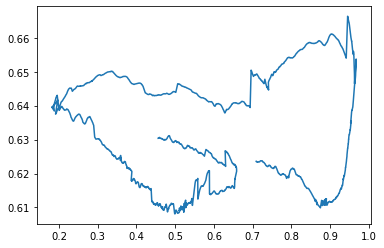

In [223]:
plt.plot(data.x/1280,data.y/720)

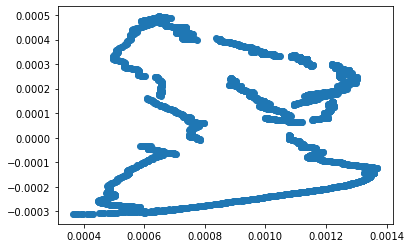

In [211]:
plt.scatter(pred[:,0]*maxes[0],pred[:,1]*maxes[1])

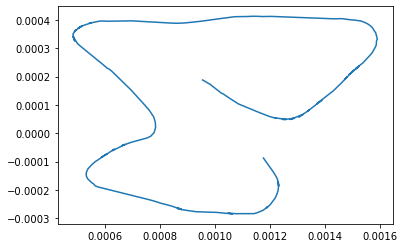

In [184]:
plt.plot(full_data_6.lon_lin.values[:],full_data_6.lat_lin.values[:])